# CMD vs Matching Distance — Results Analysis

1. Distance quality: MNIST, Synthetic, Attractors (H0 + H1 separately)
2. Classification: Synthetic, Attractors
3. Timing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr
from scipy.integrate import solve_ivp
from scipy.interpolate import griddata
from matplotlib.patches import Patch
import os, warnings
warnings.filterwarnings('ignore')

RESULTS_DIR = 'Results/'
PLOTS_DIR = 'Plots/'
os.makedirs(PLOTS_DIR, exist_ok=True)

METHODS = ['cmd', 'mdf', 'mdc']
METHOD_LABELS = {'cmd': 'CMD (11)', 'mdf': 'MD 121', 'mdc': 'MD 10'}
METHOD_COLORS = {'cmd': '#1f77b4', 'mdf': '#ff7f0e', 'mdc': '#2ca02c'}
METHOD_MARKERS = {'cmd': 'o', 'mdf': 's', 'mdc': '^'}
NOISE_LEVELS = [0.0, 0.03, 0.06, 0.09, 0.12]
N_PTS_LIST = [500, 1000, 5000]
SAVE_KW = dict(bbox_inches='tight', dpi=100)

def fmt(v): return f'{100*np.mean(v):.1f} ± {100*np.std(v):.1f}'
def fmt_latex(v): return f'${100*np.mean(v):.1f} \\pm {100*np.std(v):.1f}$'

In [5]:
# Load classification results
syn = {n: np.load(os.path.join(RESULTS_DIR, f'Synthetic_{n}.npy'), allow_pickle=True).item() for n in N_PTS_LIST}
syn_1ph = {n: np.load(os.path.join(RESULTS_DIR, f'Synthetic_1ph_{n}.npy'), allow_pickle=True).item() for n in N_PTS_LIST}
attr = np.load(os.path.join(RESULTS_DIR, 'Attractors_500.npy'), allow_pickle=True).item()
attr_1ph = np.load(os.path.join(RESULTS_DIR, 'Attractors_1ph_500.npy'), allow_pickle=True).item()

# Load distance results
mnist_d = np.load(os.path.join(RESULTS_DIR, 'MNIST_stability.npy'), allow_pickle=True).item()
syn_d = np.load(os.path.join(RESULTS_DIR, 'Synthetic_distances.npy'), allow_pickle=True).item()
attr_d = np.load(os.path.join(RESULTS_DIR, 'Attractors_distances.npy'), allow_pickle=True).item()
print('All results loaded.')

All results loaded.


---
## 1. Distance Quality

In [6]:
def distance_analysis(data, dataset_name):
    N = data['d_cmd_H0'].shape[0]
    triu = np.triu_indices(N, k=1)
    
    # Colori fissi per dimensione omologica
    H_COLORS = {'H0': '#1f77b4', 'H1': '#ff7f0e'}
    
    for hdim in ['H0', 'H1']:
        d_cmd = data[f'd_cmd_{hdim}'][triu]
        d_mdf = data[f'd_mdf_{hdim}'][triu]
        d_mdc = data[f'd_mdc_{hdim}'][triu]
        
        sp_cmd_mdf, _ = spearmanr(d_mdf, d_cmd)
        sp_mdc_mdf, _ = spearmanr(d_mdf, d_mdc)
        sp_cmd_mdc, _ = spearmanr(d_cmd, d_mdc)
        
        print(f'\n{dataset_name} — {hdim} ({len(d_cmd)} pairs):')
        print(f'  Spearman CMD vs MD121:  {sp_cmd_mdf:.4f}')
        print(f'  Spearman MD10 vs MD121: {sp_mdc_mdf:.4f}')
        print(f'  Spearman CMD vs MD10:   {sp_cmd_mdc:.4f}')
        
        color = H_COLORS[hdim]
        
        # Scatter CMD vs MD121 (CMD sulle x)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(d_cmd, d_mdf, s=0.5, alpha=0.15, color=color)
        lim = max(d_mdf.max(), d_cmd.max()) * 1.05
        ax.plot([0, lim], [0, lim], 'r--', alpha=0.7, linewidth=1)
        ax.set_xlabel('CMD', fontsize=12)
        ax.set_ylabel('MD 121', fontsize=12)
        ax.set_title(f'{dataset_name} — {hdim}', fontsize=13)
        ax.set_aspect('equal')
        ax.set_xlim([0, lim]); ax.set_ylim([0, lim])
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f'{dataset_name.lower()}_{hdim}_cmd_vs_md121.pdf'), **SAVE_KW)
        plt.show()
        
        # Scatter CMD vs MD10 (CMD sulle x)
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(d_cmd, d_mdc, s=0.5, alpha=0.15, color=color)
        lim = max(d_cmd.max(), d_mdc.max()) * 1.05
        ax.plot([0, lim], [0, lim], 'r--', alpha=0.7, linewidth=1)
        ax.set_xlabel('CMD', fontsize=12)
        ax.set_ylabel('MD 10', fontsize=12)
        ax.set_title(f'{dataset_name} — {hdim}', fontsize=13)
        ax.set_aspect('equal')
        ax.set_xlim([0, lim]); ax.set_ylim([0, lim])
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f'{dataset_name.lower()}_{hdim}_cmd_vs_md10.pdf'), **SAVE_KW)
        plt.show()


MNIST — H0 (499500 pairs):
  Spearman CMD vs MD121:  0.9800
  Spearman MD10 vs MD121: 0.9258
  Spearman CMD vs MD10:   0.9085


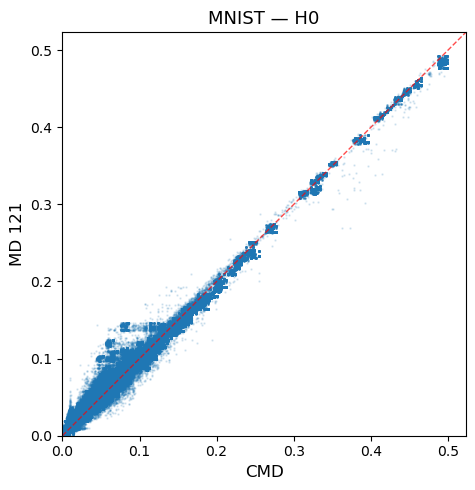

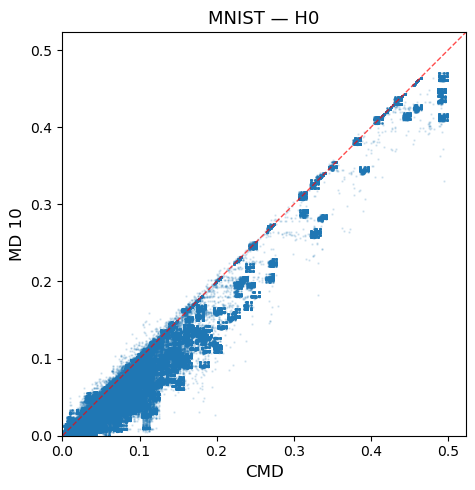


MNIST — H1 (499500 pairs):
  Spearman CMD vs MD121:  0.9929
  Spearman MD10 vs MD121: 0.9552
  Spearman CMD vs MD10:   0.9421


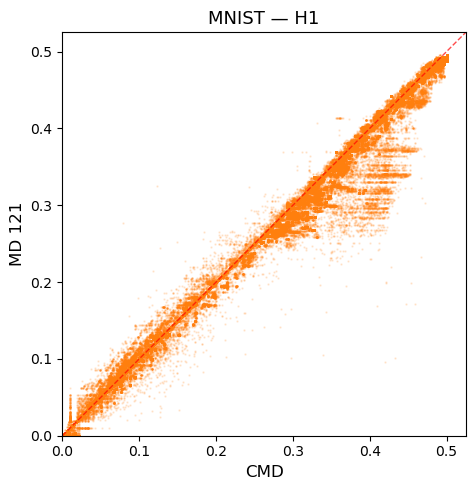

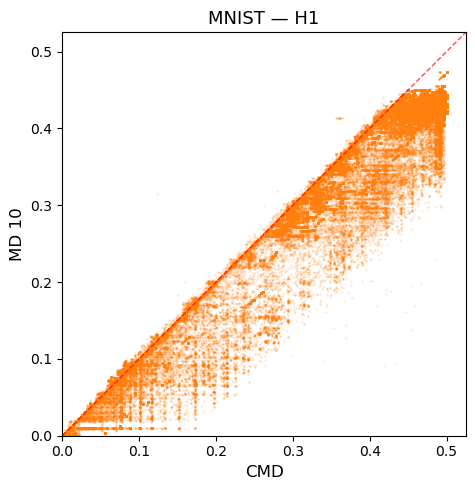

In [7]:
distance_analysis(mnist_d, 'MNIST')


Synthetic — H0 (124750 pairs):
  Spearman CMD vs MD121:  0.9973
  Spearman MD10 vs MD121: 0.9920
  Spearman CMD vs MD10:   0.9917


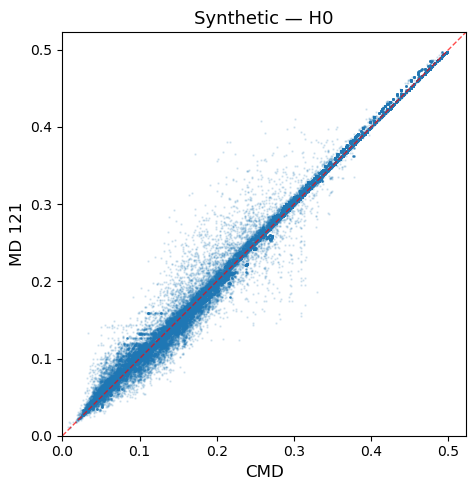

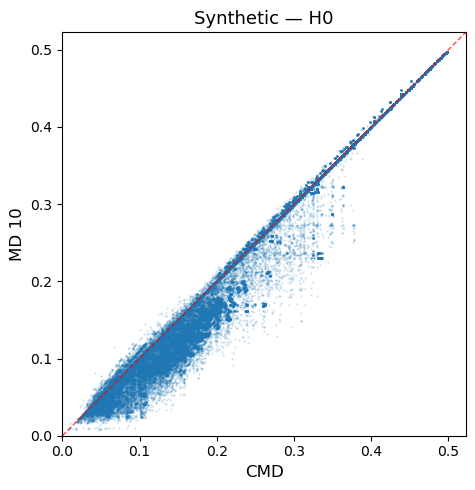


Synthetic — H1 (124750 pairs):
  Spearman CMD vs MD121:  0.9705
  Spearman MD10 vs MD121: 0.9721
  Spearman CMD vs MD10:   0.9876


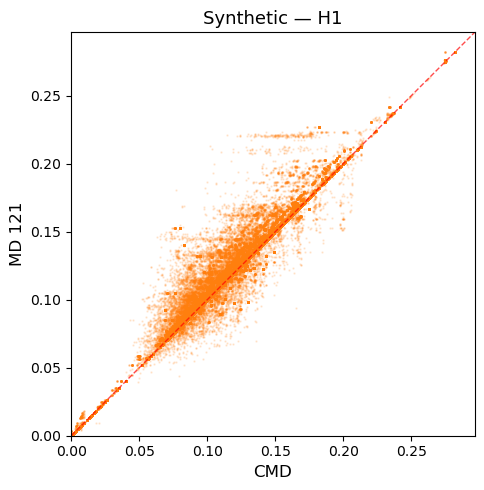

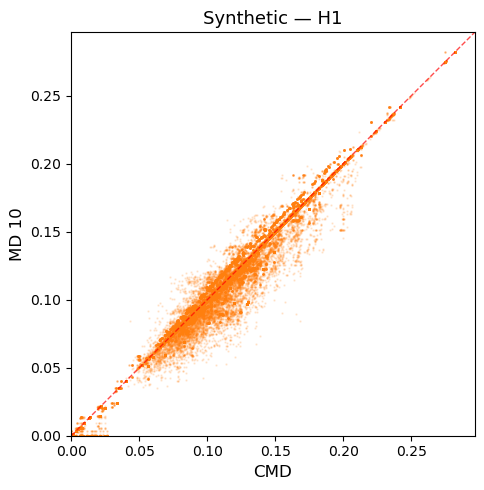

In [8]:
distance_analysis(syn_d, 'Synthetic')


Attractors — H0 (499500 pairs):
  Spearman CMD vs MD121:  0.9999
  Spearman MD10 vs MD121: 0.9998
  Spearman CMD vs MD10:   0.9997


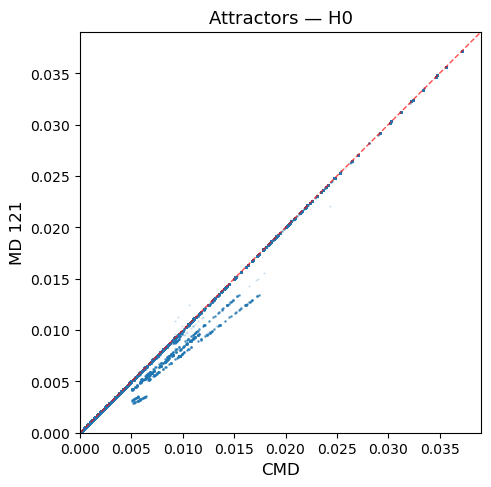

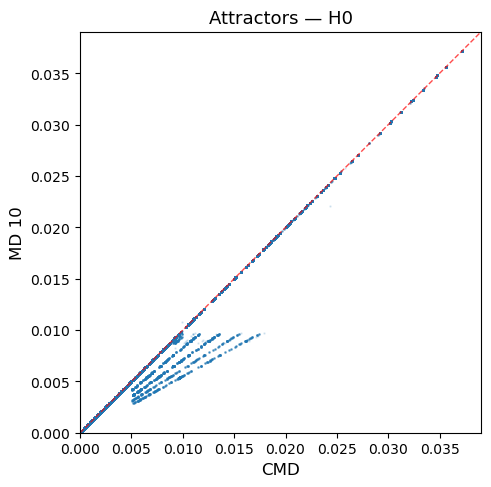


Attractors — H1 (499500 pairs):
  Spearman CMD vs MD121:  0.9958
  Spearman MD10 vs MD121: 0.9915
  Spearman CMD vs MD10:   0.9819


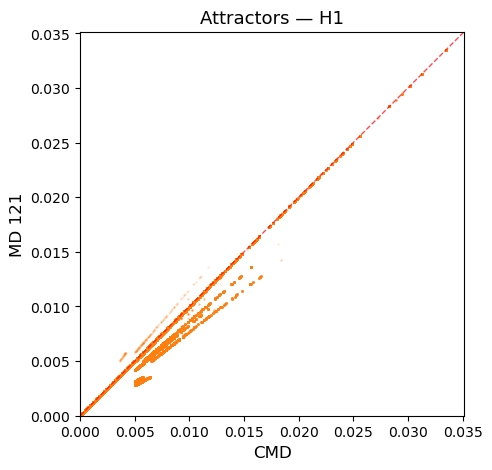

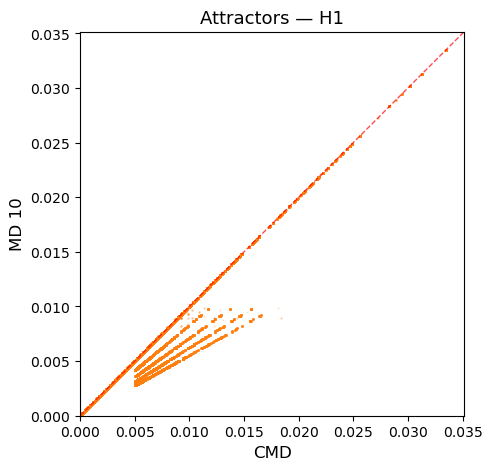

In [9]:
distance_analysis(attr_d, 'Attractors')

---
## 2. Synthetic Shapes — Classification

In [10]:

def generate_circle(n, noise=0.0):
    theta = np.random.uniform(0, 2*np.pi, n)
    pts = np.column_stack([0.5+0.4*np.cos(theta), 0.5*np.ones(n), 0.5+0.4*np.sin(theta)])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_sphere(n, noise=0.0):
    phi = np.random.uniform(0, 2*np.pi, n)
    cos_theta = np.random.uniform(-1, 1, n)
    sin_theta = np.sqrt(1 - cos_theta**2)
    pts = np.column_stack([0.5+0.4*sin_theta*np.cos(phi), 0.5+0.4*sin_theta*np.sin(phi), 0.5+0.4*cos_theta])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_torus(n, noise=0.0):
    """Torus, center (0.5, 0.5, 0.5), R=0.3, r=0.1."""
    R, r = 0.3, 0.1
    theta = np.random.uniform(0, 2 * np.pi, n)
    phi = np.random.uniform(0, 2 * np.pi, n)
    pts = np.column_stack([0.5 + (R + r*np.cos(phi)) * np.cos(theta),
                           0.5 + (R + r*np.cos(phi)) * np.sin(theta),
                           0.5 + r * np.sin(phi)])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_three_clusters(n, noise=0.0):
    centers = np.array([[0.25,0.25,0.5],[0.75,0.25,0.5],[0.5,0.75,0.5]])
    n_per = n // 3
    parts = [c + np.random.normal(0, 0.06, (n_per if i < 2 else n-2*n_per, 3)) for i, c in enumerate(centers)]
    pts = np.vstack(parts)
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def generate_two_circles(n, noise=0.0):
    n1 = n // 2; n2 = n - n1
    t1 = np.random.uniform(0, 2*np.pi, n1)
    t2 = np.random.uniform(0, 2*np.pi, n2)
    pts = np.vstack([
        np.column_stack([0.5+0.2*np.cos(t1), 0.5+0.2*np.sin(t1), 0.5*np.ones(n1)]),
        np.column_stack([0.5+0.4*np.cos(t2), 0.5+0.4*np.sin(t2), 0.5*np.ones(n2)])])
    if noise > 0: pts += np.random.normal(0, noise, pts.shape)
    return pts

def compute_eccentricity(pts):
    """Compute eccentricity (max distance) for each point, normalized to [0,1]"""
    D = squareform(pdist(pts))
    ecc = np.max(D, axis=1)
    return (ecc - ecc.min()) / (ecc.max() - ecc.min())

generators = [generate_circle, generate_sphere, generate_torus, generate_three_clusters, generate_two_circles]
shape_names = ['Circle', 'Sphere', 'Torus', '3 Clusters', '2 Circles']

PLOTS_DIR = 'Plots'
os.makedirs(PLOTS_DIR, exist_ok=True)
SAVE_KW = {'bbox_inches': 'tight', 'dpi': 300}

from scipy.spatial.distance import pdist, squareform

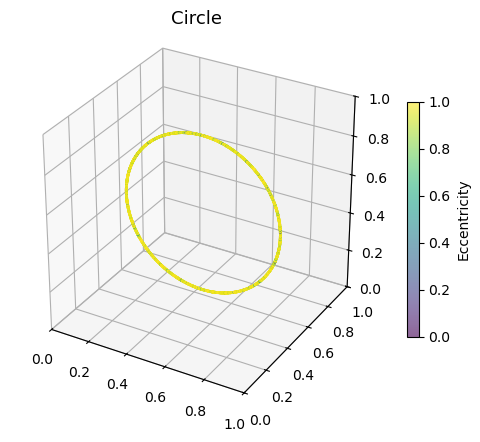

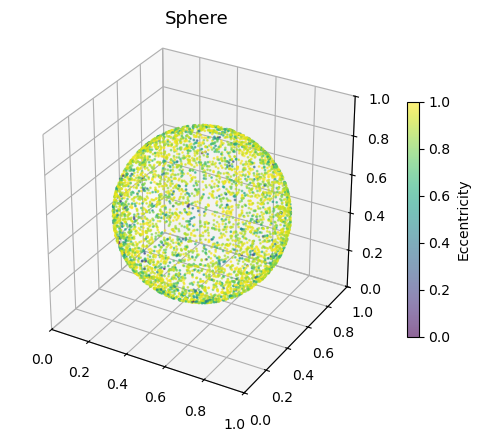

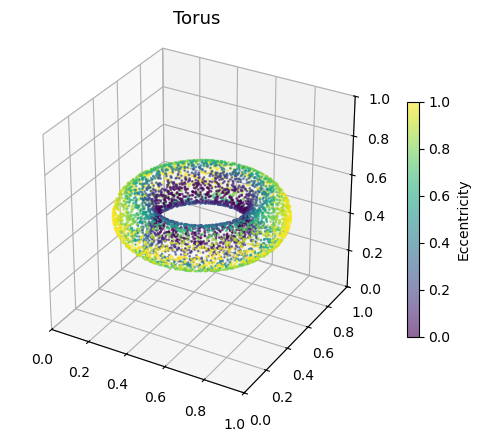

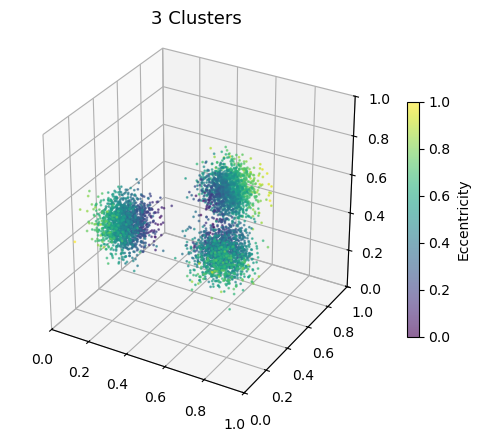

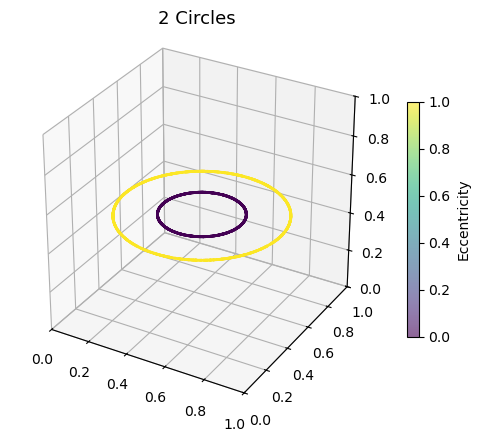

In [11]:
np.random.seed(0)
for i, (gen, name) in enumerate(zip(generators, shape_names)):
    pts = gen(5000, noise=0.0)
    ecc = compute_eccentricity(pts)
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], 
                        c=ecc, cmap='viridis', s=1, alpha=0.6)
    ax.set_title(name, fontsize=13)
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1]); ax.set_zlim([0, 1])
    ax.set_box_aspect([1,1,1])
    plt.colorbar(scatter, ax=ax, shrink=0.5, label='Eccentricity')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'synthetic_{name.lower().replace(" ", "_")}.pdf'), **SAVE_KW)
    plt.show()
np.random.seed(42)

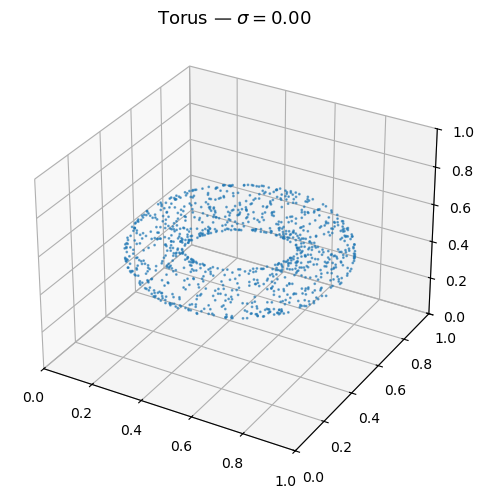

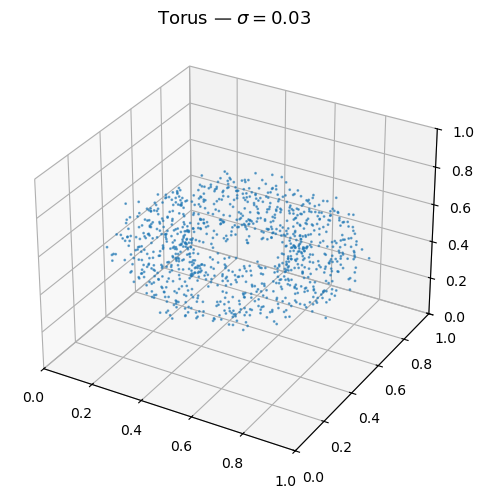

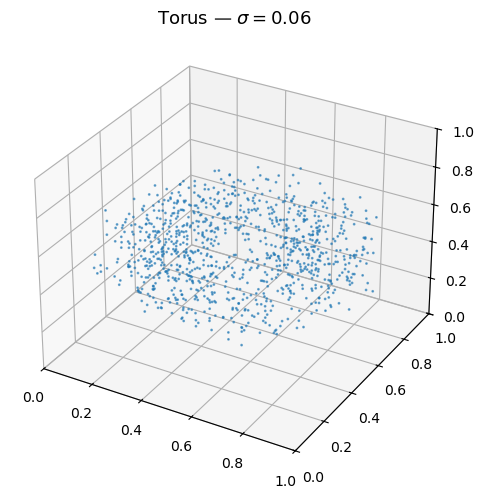

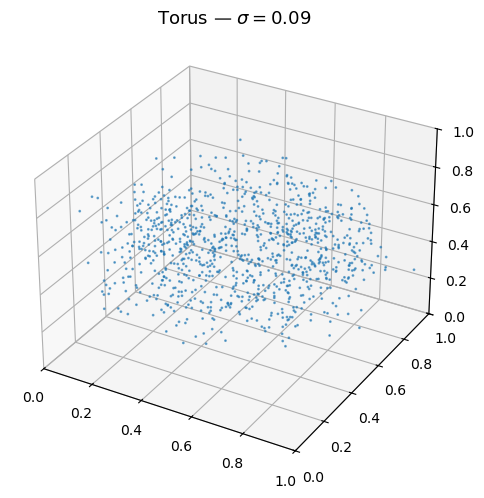

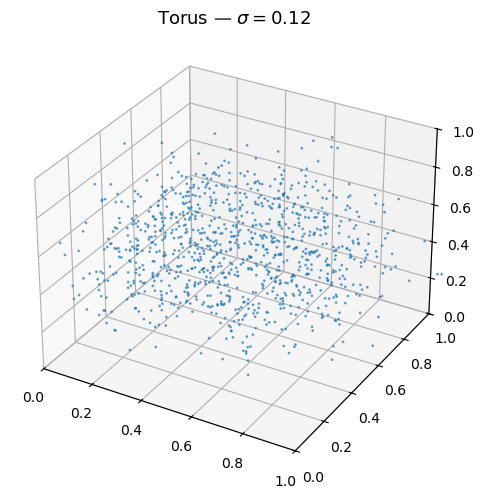

In [12]:
# Torus at each noise level
np.random.seed(0)
for noise in NOISE_LEVELS:
    pts = generate_torus(1000, noise=noise)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1, alpha=0.6)
    ax.set_title(f'Torus — $\\sigma = {noise:.2f}$', fontsize=13)
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1]); ax.set_zlim([0, 1])
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'torus_noise_{noise:.2f}.pdf'), **SAVE_KW)
    plt.show()
np.random.seed(42)

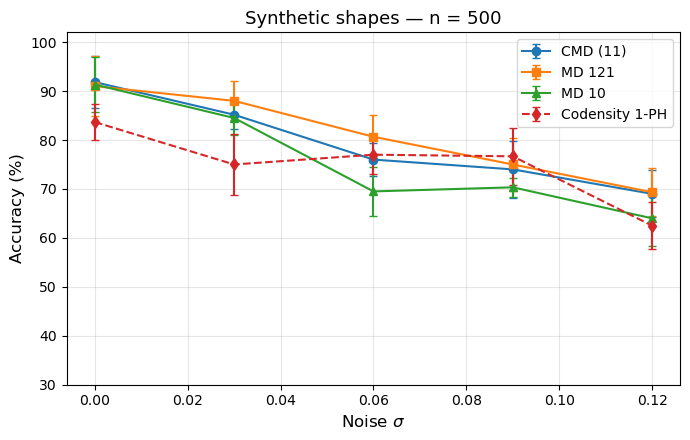

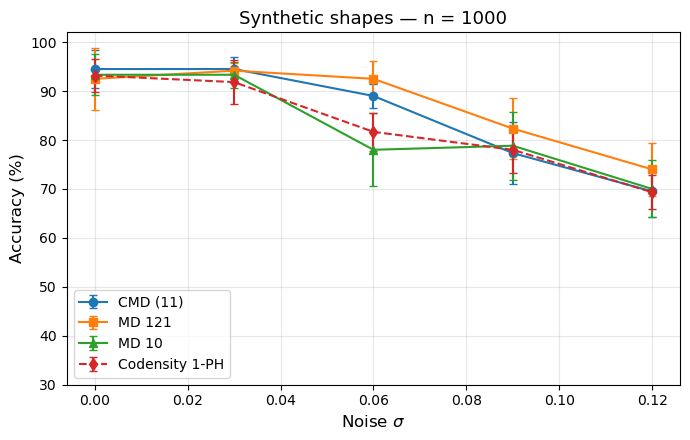

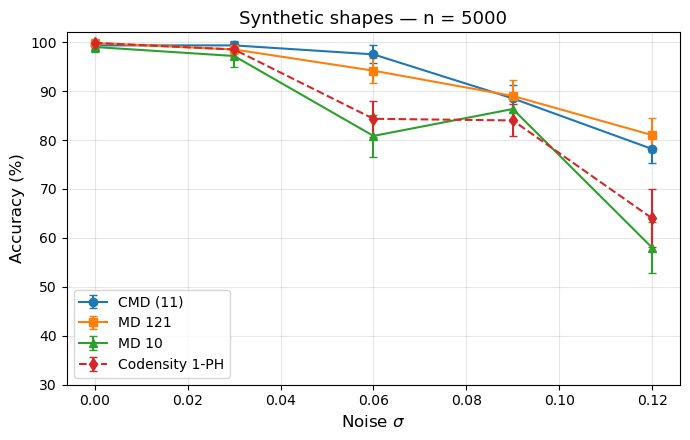

In [13]:
# Accuracy vs noise (one per n, with codensity 1-PH)
for n_pts in N_PTS_LIST:
    fig, ax = plt.subplots(figsize=(7, 4.5))
    for m in METHODS:
        means = [100*np.mean(syn[n_pts][s][m]) for s in NOISE_LEVELS]
        stds  = [100*np.std(syn[n_pts][s][m])  for s in NOISE_LEVELS]
        ax.errorbar(NOISE_LEVELS, means, yerr=stds,
                    marker=METHOD_MARKERS[m], color=METHOD_COLORS[m],
                    label=METHOD_LABELS[m], capsize=3, linewidth=1.5)
    means_cod = [100*np.mean(syn_1ph[n_pts][s]['Codensity lower-star']) for s in NOISE_LEVELS]
    stds_cod  = [100*np.std(syn_1ph[n_pts][s]['Codensity lower-star'])  for s in NOISE_LEVELS]
    ax.errorbar(NOISE_LEVELS, means_cod, yerr=stds_cod,
                marker='d', color='#d62728', linestyle='--',
                label='Codensity 1-PH', capsize=3, linewidth=1.5)
    ax.set_xlabel(r'Noise $\sigma$', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'Synthetic shapes — n = {n_pts}', fontsize=13)
    ax.legend(fontsize=10); ax.set_ylim([30, 102]); ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'synthetic_n{n_pts}.pdf'), **SAVE_KW)
    plt.show()

In [14]:
# Surface data
sigma_vals = np.array(NOISE_LEVELS)
n_vals = np.array(N_PTS_LIST)
acc_grids = {}
for m in METHODS:
    grid = np.zeros((len(sigma_vals), len(n_vals)))
    for i, s in enumerate(sigma_vals):
        for j, nv in enumerate(n_vals):
            grid[i, j] = 100 * np.mean(syn[nv][s][m])
    acc_grids[m] = grid
S, N_g = np.meshgrid(sigma_vals, n_vals, indexing='ij')

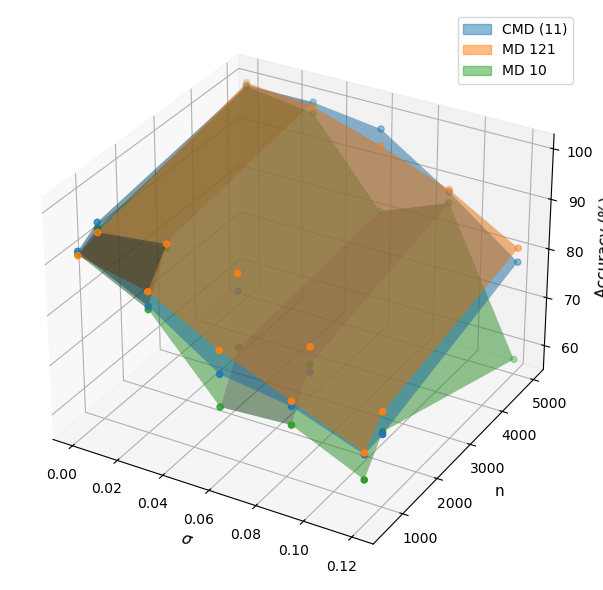

In [15]:
# Surface raw
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for m in METHODS:
    ax.plot_surface(S, N_g, acc_grids[m], alpha=0.5, color=METHOD_COLORS[m])
    ax.scatter(S.ravel(), N_g.ravel(), acc_grids[m].ravel(), color=METHOD_COLORS[m], s=20)
ax.set_xlabel(r'$\sigma$', fontsize=11); ax.set_ylabel('n', fontsize=11); ax.set_zlabel('Accuracy (%)', fontsize=11)
ax.legend(handles=[Patch(color=METHOD_COLORS[m], alpha=0.5, label=METHOD_LABELS[m]) for m in METHODS], fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'synthetic_surface_raw.pdf'), **SAVE_KW)
plt.show()

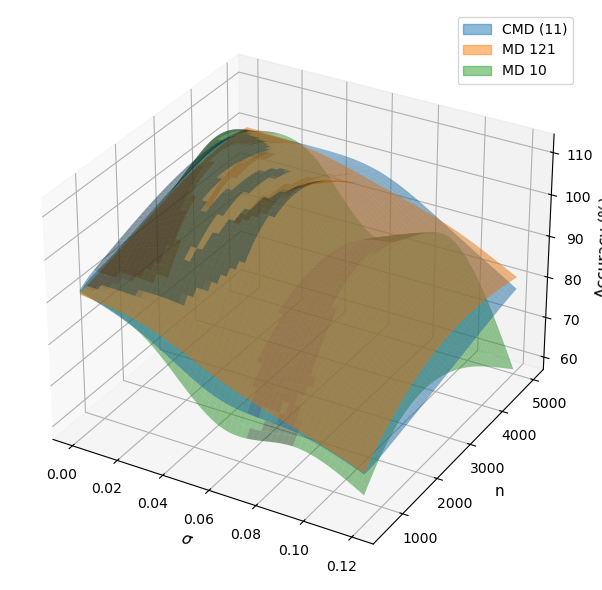

In [16]:
# Surface interpolated
sigma_fine = np.linspace(0, 0.12, 50)
n_fine = np.linspace(500, 5000, 50)
S_fine, N_fine = np.meshgrid(sigma_fine, n_fine, indexing='ij')
points = np.column_stack([S.ravel(), N_g.ravel()])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for m in METHODS:
    Z_fine = griddata(points, acc_grids[m].ravel(), (S_fine, N_fine), method='cubic')
    ax.plot_surface(S_fine, N_fine, Z_fine, alpha=0.5, color=METHOD_COLORS[m])
ax.set_xlabel(r'$\sigma$', fontsize=11); ax.set_ylabel('n', fontsize=11); ax.set_zlabel('Accuracy (%)', fontsize=11)
ax.legend(handles=[Patch(color=METHOD_COLORS[m], alpha=0.5, label=METHOD_LABELS[m]) for m in METHODS], fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'synthetic_surface_smooth.pdf'), **SAVE_KW)
plt.show()

In [17]:
# Python tables
for n_pts in N_PTS_LIST:
    print(f'\nSynthetic n = {n_pts}')
    print('=' * 75)
    print(f'{"σ":<8} {"CMD (11)":<22} {"MD 121":<22} {"MD 10":<22}')
    print('-' * 75)
    for noise in NOISE_LEVELS:
        r = syn[n_pts][noise]
        print(f'{noise:<8.2f} {fmt(r["cmd"]):<22} {fmt(r["mdf"]):<22} {fmt(r["mdc"]):<22}')
    print('=' * 75)


Synthetic n = 500
σ        CMD (11)               MD 121                 MD 10                 
---------------------------------------------------------------------------
0.00     91.8 ± 5.3             91.0 ± 6.2             91.3 ± 5.6            
0.03     85.2 ± 2.8             88.0 ± 4.0             84.5 ± 3.4            
0.06     76.0 ± 3.3             80.7 ± 4.4             69.5 ± 5.1            
0.09     74.0 ± 5.9             75.0 ± 5.3             70.3 ± 1.9            
0.12     69.0 ± 4.8             69.3 ± 4.9             64.0 ± 5.7            

Synthetic n = 1000
σ        CMD (11)               MD 121                 MD 10                 
---------------------------------------------------------------------------
0.00     94.5 ± 3.9             92.5 ± 6.4             93.3 ± 4.1            
0.03     94.5 ± 2.5             94.2 ± 1.5             93.3 ± 2.7            
0.06     89.0 ± 2.4             92.5 ± 3.6             78.0 ± 7.4            
0.09     77.3 ± 6.4          

In [18]:
# LaTeX table
print(r'\begin{table}[ht]')
print(r'\centering')
print(r'\caption{Classification accuracy (\%) on synthetic shapes.}')
print(r'\label{tab:synthetic}')
print(r'\begin{tabular}{cc|ccc}')
print(r'\toprule')
print(r'$n$ & $\sigma$ & CMD (11) & MD 121 & MD 10 \\\\')
print(r'\midrule')
for n_pts in N_PTS_LIST:
    for i, noise in enumerate(NOISE_LEVELS):
        r = syn[n_pts][noise]
        n_str = str(n_pts) if i == 0 else ''
        print(f'{n_str} & {noise:.2f} & {fmt_latex(r["cmd"])} & {fmt_latex(r["mdf"])} & {fmt_latex(r["mdc"])} \\\\\\\\')
    if n_pts != N_PTS_LIST[-1]: print(r'\midrule')
print(r'\bottomrule')
print(r'\end{tabular}')
print(r'\end{table}')

\begin{table}[ht]
\centering
\caption{Classification accuracy (\%) on synthetic shapes.}
\label{tab:synthetic}
\begin{tabular}{cc|ccc}
\toprule
$n$ & $\sigma$ & CMD (11) & MD 121 & MD 10 \\\\
\midrule
500 & 0.00 & $91.8 \pm 5.3$ & $91.0 \pm 6.2$ & $91.3 \pm 5.6$ \\\\
 & 0.03 & $85.2 \pm 2.8$ & $88.0 \pm 4.0$ & $84.5 \pm 3.4$ \\\\
 & 0.06 & $76.0 \pm 3.3$ & $80.7 \pm 4.4$ & $69.5 \pm 5.1$ \\\\
 & 0.09 & $74.0 \pm 5.9$ & $75.0 \pm 5.3$ & $70.3 \pm 1.9$ \\\\
 & 0.12 & $69.0 \pm 4.8$ & $69.3 \pm 4.9$ & $64.0 \pm 5.7$ \\\\
\midrule
1000 & 0.00 & $94.5 \pm 3.9$ & $92.5 \pm 6.4$ & $93.3 \pm 4.1$ \\\\
 & 0.03 & $94.5 \pm 2.5$ & $94.2 \pm 1.5$ & $93.3 \pm 2.7$ \\\\
 & 0.06 & $89.0 \pm 2.4$ & $92.5 \pm 3.6$ & $78.0 \pm 7.4$ \\\\
 & 0.09 & $77.3 \pm 6.4$ & $82.3 \pm 6.3$ & $78.8 \pm 6.9$ \\\\
 & 0.12 & $69.5 \pm 5.2$ & $74.0 \pm 5.4$ & $70.0 \pm 5.8$ \\\\
\midrule
5000 & 0.00 & $99.3 \pm 0.8$ & $99.8 \pm 0.5$ & $99.0 \pm 1.1$ \\\\
 & 0.03 & $99.3 \pm 0.8$ & $98.5 \pm 0.9$ & $97.2 \pm 2.2$ \\\\
 &

In [19]:
# 1-PH baselines: python
PH1_METHODS = ['Alpha 1-PH', 'Codensity lower-star', 'Ecc lower-star']
for n_pts in N_PTS_LIST:
    print(f'\n1-PH Baselines n = {n_pts}')
    print('=' * 80)
    print(f'{"σ":<8} {"Alpha 1-PH":<22} {"Codensity LS":<22} {"Ecc LS":<22}')
    print('-' * 80)
    for noise in NOISE_LEVELS:
        r = syn_1ph[n_pts][noise]
        print(f'{noise:<8.2f} {fmt(r["Alpha 1-PH"]):<22} {fmt(r["Codensity lower-star"]):<22} {fmt(r["Ecc lower-star"]):<22}')
    print('=' * 80)


1-PH Baselines n = 500
σ        Alpha 1-PH             Codensity LS           Ecc LS                
--------------------------------------------------------------------------------
0.00     65.2 ± 12.7            83.7 ± 3.7             75.2 ± 5.6            
0.03     51.3 ± 10.0            75.0 ± 6.2             24.2 ± 3.7            
0.06     36.5 ± 7.9             77.0 ± 4.0             20.5 ± 2.5            
0.09     36.5 ± 3.0             76.7 ± 5.8             19.2 ± 3.0            
0.12     25.5 ± 3.7             62.5 ± 4.8             21.3 ± 2.2            

1-PH Baselines n = 1000
σ        Alpha 1-PH             Codensity LS           Ecc LS                
--------------------------------------------------------------------------------
0.00     61.2 ± 14.2            93.2 ± 3.4             71.3 ± 7.8            
0.03     48.0 ± 8.7             91.8 ± 4.4             23.5 ± 4.2            
0.06     34.0 ± 9.2             81.7 ± 3.9             22.0 ± 2.9            
0.09     

In [20]:
# 1-PH baselines: LaTeX
print(r'\begin{table}[ht]')
print(r'\centering')
print(r'\caption{1-PH baselines on synthetic shapes.}')
print(r'\label{tab:synthetic_1ph}')
print(r'\begin{tabular}{cc|ccc}')
print(r'\toprule')
print(r'$n$ & $\sigma$ & Alpha 1-PH & Codensity LS & Ecc LS \\\\')
print(r'\midrule')
for n_pts in N_PTS_LIST:
    for i, noise in enumerate(NOISE_LEVELS):
        r = syn_1ph[n_pts][noise]
        n_str = str(n_pts) if i == 0 else ''
        print(f'{n_str} & {noise:.2f} & {fmt_latex(r["Alpha 1-PH"])} & {fmt_latex(r["Codensity lower-star"])} & {fmt_latex(r["Ecc lower-star"])} \\\\\\\\')
    if n_pts != N_PTS_LIST[-1]: print(r'\midrule')
print(r'\bottomrule')
print(r'\end{tabular}')
print(r'\end{table}')

\begin{table}[ht]
\centering
\caption{1-PH baselines on synthetic shapes.}
\label{tab:synthetic_1ph}
\begin{tabular}{cc|ccc}
\toprule
$n$ & $\sigma$ & Alpha 1-PH & Codensity LS & Ecc LS \\\\
\midrule
500 & 0.00 & $65.2 \pm 12.7$ & $83.7 \pm 3.7$ & $75.2 \pm 5.6$ \\\\
 & 0.03 & $51.3 \pm 10.0$ & $75.0 \pm 6.2$ & $24.2 \pm 3.7$ \\\\
 & 0.06 & $36.5 \pm 7.9$ & $77.0 \pm 4.0$ & $20.5 \pm 2.5$ \\\\
 & 0.09 & $36.5 \pm 3.0$ & $76.7 \pm 5.8$ & $19.2 \pm 3.0$ \\\\
 & 0.12 & $25.5 \pm 3.7$ & $62.5 \pm 4.8$ & $21.3 \pm 2.2$ \\\\
\midrule
1000 & 0.00 & $61.2 \pm 14.2$ & $93.2 \pm 3.4$ & $71.3 \pm 7.8$ \\\\
 & 0.03 & $48.0 \pm 8.7$ & $91.8 \pm 4.4$ & $23.5 \pm 4.2$ \\\\
 & 0.06 & $34.0 \pm 9.2$ & $81.7 \pm 3.9$ & $22.0 \pm 2.9$ \\\\
 & 0.09 & $38.2 \pm 4.0$ & $78.0 \pm 4.6$ & $24.8 \pm 6.8$ \\\\
 & 0.12 & $31.5 \pm 3.8$ & $69.3 \pm 3.5$ & $22.2 \pm 6.4$ \\\\
\midrule
5000 & 0.00 & $57.8 \pm 10.5$ & $99.8 \pm 0.5$ & $78.3 \pm 6.1$ \\\\
 & 0.03 & $46.8 \pm 11.9$ & $98.5 \pm 1.6$ & $25.0 \pm 4.0$ \\\

---
## 3. Chaotic Attractors — Classification

In [21]:
def lorenz_rhs(t, s):
    x, y, z = s
    return [10.0*(y-x), x*(28.0-z)-y, x*y-8.0/3.0*z]
def rossler_rhs(t, s):
    x, y, z = s
    return [-(y+z), x+0.2*y, 0.2+z*(x-5.7)]
def thomas_rhs(t, s):
    x, y, z = s
    b = 0.208186
    return [np.sin(y)-b*x, np.sin(z)-b*y, np.sin(x)-b*z]
def sprott_rhs(t, s):
    x, y, z = s
    return [y+2.07*x*y+x*z, 1.0-1.79*x**2+y*z, x-x**2-y**2]
def fourwing_rhs(t, s):
    x, y, z = s
    return [0.2*x+y*z, 0.01*x-0.4*y-x*z, -z-x*y]
attractor_configs = [(lorenz_rhs,20,100,5.0),(rossler_rhs,50,200,1.0),(thomas_rhs,100,500,1.0),(sprott_rhs,50,200,0.5),(fourwing_rhs,50,300,0.1)]
attractor_names = ['Lorenz', 'Rössler', 'Thomas', 'Sprott', 'Four-Wing']

def generate_attractor_trajectory(cls_idx, n_pts=5000, seed=42):
    rhs, t_burn, t_run, x0_scale = attractor_configs[cls_idx]
    rng = np.random.RandomState(seed)
    x0 = rng.uniform(-x0_scale, x0_scale, 3)
    sol0 = solve_ivp(rhs, [0, t_burn], x0, rtol=1e-8, atol=1e-8, dense_output=True)
    y0 = sol0.y[:, -1]
    t_eval = np.linspace(0, t_run, max(20000, 20*n_pts))
    sol = solve_ivp(rhs, [0, t_run], y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)
    traj = sol.y.T
    pmin, pmax = traj.min(axis=0), traj.max(axis=0)
    rng_vals = pmax - pmin; rng_vals[rng_vals < 1e-12] = 1.0
    return (traj - pmin) / rng_vals

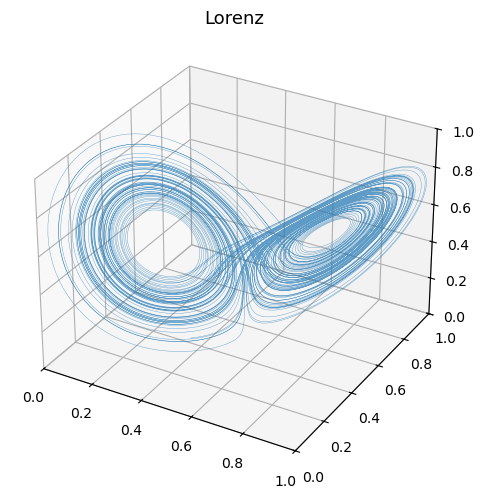

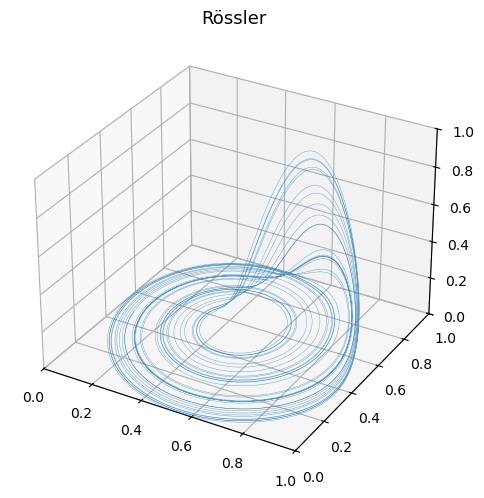

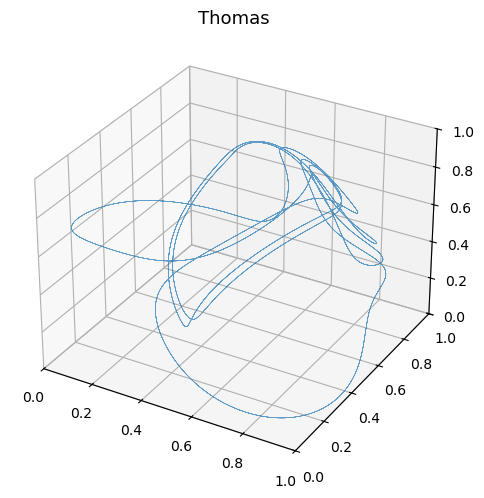

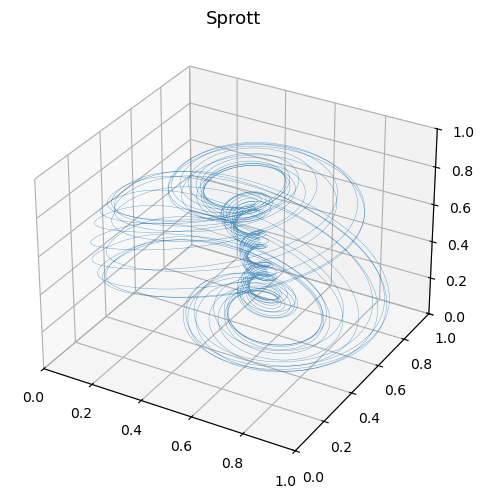

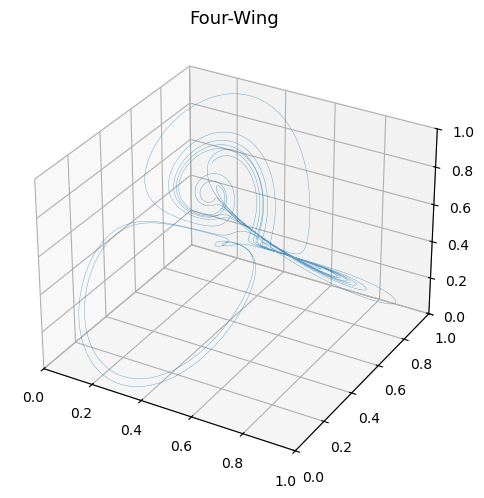

In [22]:
# Plot attractors as trajectories
for i, name in enumerate(attractor_names):
    traj = generate_attractor_trajectory(i, n_pts=500, seed=42)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], linewidth=0.3, alpha=0.7, color='#1f77b4')
    ax.set_title(name, fontsize=13)
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1]); ax.set_zlim([0, 1])
    plt.tight_layout()
    fname = name.lower().replace('ö', 'o').replace('-', '').replace(' ', '')
    plt.savefig(os.path.join(PLOTS_DIR, f'attractor_{fname}.pdf'), **SAVE_KW)
    plt.show()

In [23]:
# Python table
print('Attractors — n = 500')
print('=' * 65)
print(f'{"CMD (11)":<22} {"MD 121":<22} {"MD 10":<22}')
print('-' * 65)
r = attr[0]
print(f'{fmt(r["cmd"]):<22} {fmt(r["mdf"]):<22} {fmt(r["mdc"]):<22}')
print('=' * 65)

Attractors — n = 500
CMD (11)               MD 121                 MD 10                 
-----------------------------------------------------------------
95.2 ± 1.9             96.5 ± 2.4             93.8 ± 3.4            


In [24]:
# LaTeX table
print(r'\begin{table}[ht]')
print(r'\centering')
print(r'\caption{Classification accuracy (\%) on chaotic attractors ($n=500$).}')
print(r'\label{tab:attractors}')
print(r'\begin{tabular}{ccc}')
print(r'\toprule')
print(r'CMD (11) & MD 121 & MD 10 \\\\')
print(r'\midrule')
r = attr[0]
print(f'{fmt_latex(r["cmd"])} & {fmt_latex(r["mdf"])} & {fmt_latex(r["mdc"])} \\\\\\\\')
print(r'\bottomrule')
print(r'\end{tabular}')
print(r'\end{table}')

\begin{table}[ht]
\centering
\caption{Classification accuracy (\%) on chaotic attractors ($n=500$).}
\label{tab:attractors}
\begin{tabular}{ccc}
\toprule
CMD (11) & MD 121 & MD 10 \\\\
\midrule
$95.2 \pm 1.9$ & $96.5 \pm 2.4$ & $93.8 \pm 3.4$ \\\\
\bottomrule
\end{tabular}
\end{table}


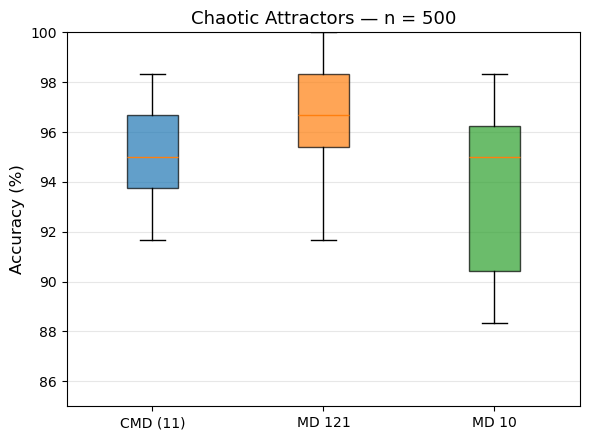

In [25]:
# Boxplot
r = attr[0]
fig, ax = plt.subplots(figsize=(6, 4.5))
data_box = [100*np.array(r[m]) for m in METHODS]
bp = ax.boxplot(data_box, labels=[METHOD_LABELS[m] for m in METHODS], patch_artist=True)
for patch, m in zip(bp['boxes'], METHODS):
    patch.set_facecolor(METHOD_COLORS[m]); patch.set_alpha(0.7)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Chaotic Attractors — n = 500', fontsize=13)
ax.set_ylim([85, 100]); ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'attractors_boxplot.pdf'), **SAVE_KW)
plt.show()

---
## 4. Timing

In [33]:
import gudhi as gd
from sklearn.datasets import fetch_openml
import time

print('Fetching MNIST...')
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X_all, y_all = mnist.data, mnist.target.astype(int)
digit_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_ex_timing = 15
Data_img = []
rng = np.random.RandomState(42)
for digit in digit_classes:
    indices = np.where(y_all == digit)[0]
    chosen = rng.choice(indices, size=n_ex_timing, replace=False)
    for idx in chosen:
        Data_img.append(X_all[idx].reshape(28, 28).astype(float))
N_timing = len(Data_img)
print(f'Using {N_timing} images')

Fetching MNIST...
Using 150 images


In [35]:
t_values_t = np.linspace(0, 1, 11)
a_fine_t = np.linspace(0.05, 0.95, 11)
b_fine_t = np.linspace(0, 1, 11)
a_coarse_t = np.array([0.25, 0.75])
b_coarse_t = np.linspace(0, 1, 5)

def build_filtrations_t(img):
    h, w = img.shape
    yy, xx = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    cy, cx = h/2.0, w/2.0
    phi1 = 1.0 - img / 255.0
    binary = img > 50
    radial = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    radial = radial / radial.max()
    phi2 = np.ones((h, w))
    phi2[binary] = radial[binary]
    return phi1, phi2

def cubical_pd_t(filt_2d):
    h, w = filt_2d.shape
    cc = gd.CubicalComplex(dimensions=[h, w], top_dimensional_cells=filt_2d.flatten())
    cc.persistence()
    pds = []
    for dim in range(2):
        pd = cc.persistence_intervals_in_dimension(dim)
        if pd is not None and len(pd) > 0: pd = pd[np.isfinite(pd[:, 1])]
        if pd is None or len(pd) == 0: pd = np.empty((0, 2))
        pds.append(pd)
    return tuple(pds)

def phi_star_ab_t(phi1, phi2, a, b):
    return np.minimum(a, 1-a) * np.maximum((phi1-b)/a, (phi2+b)/(1-a))

def safe_bottleneck_t(pd1, pd2, e=0.01):
    if len(pd1) == 0 and len(pd2) == 0: return 0.0
    if len(pd1) == 0: return float(np.max((pd2[:,1]-pd2[:,0])/2))
    if len(pd2) == 0: return float(np.max((pd1[:,1]-pd1[:,0])/2))
    return gd.bottleneck_distance(pd1, pd2, e)

Phi1_t, Phi2_t = [], []
for img in Data_img:
    p1, p2 = build_filtrations_t(img)
    Phi1_t.append(p1); Phi2_t.append(p2)

def make_cmd_t(p1, p2): return [(1-t)*p1 + t*p2 for t in t_values_t]
def make_mdf_t(p1, p2): return [phi_star_ab_t(p1, p2, a, b) for a in a_fine_t for b in b_fine_t]
def make_mdc_t(p1, p2): return [phi_star_ab_t(p1, p2, a, b) for a in a_coarse_t for b in b_coarse_t]

timing_methods = [('CMD (11)', make_cmd_t, 11), ('MD 121', make_mdf_t, 121), ('MD 10', make_mdc_t, 10)]

times = {}
for mname, make_filts, n_params in timing_methods:
    t0 = time.time()
    PDs = [None] * N_timing
    for i in range(N_timing):
        PDs[i] = [cubical_pd_t(f) for f in make_filts(Phi1_t[i], Phi2_t[i])]
    t_pds = time.time() - t0
    t0 = time.time()
    for i in range(N_timing):
        for j in range(i+1, N_timing):
            max_d = 0.0
            for p in range(n_params):
                for dim in range(2):
                    d = safe_bottleneck_t(PDs[i][p][dim], PDs[j][p][dim])
                    if d > max_d: max_d = d
    t_dist = time.time() - t0
    times[mname] = (t_pds, t_dist, t_pds + t_dist)
    print(f'{mname:>10}: PDs={t_pds:.1f}s, Distances={t_dist:.1f}s, Total={t_pds+t_dist:.1f}s')

t_cmd = times['CMD (11)'][2]
print(f'\nRatios:')
print(f'  MD 121 / CMD = {times["MD 121"][2] / t_cmd:.1f}x')
print(f'  MD 10 / CMD  = {times["MD 10"][2] / t_cmd:.1f}x')

  CMD (11): PDs=1.3s, Distances=1.5s, Total=2.8s
    MD 121: PDs=13.2s, Distances=12.2s, Total=25.4s
     MD 10: PDs=1.2s, Distances=1.1s, Total=2.2s

Ratios:
  MD 121 / CMD = 9.0x
  MD 10 / CMD  = 0.8x
